<a href="https://colab.research.google.com/github/michaelsong4399/asteroseismology/blob/master/NNLightCurveProg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lightkurve
!pip install astroquery
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install pandas
!pip install tensorflow
!pip install astropy

     |████████████████████████████████| 235kB 11.6MB/s 
     |████████████████████████████████| 788kB 25.7MB/s 
     |████████████████████████████████| 6.5MB 19.0MB/s 
     |████████████████████████████████| 256kB 56.0MB/s 
     |████████████████████████████████| 22.3MB 1.5MB/s 
     |████████████████████████████████| 3.4MB 41.6MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 368kB 50.4MB/s 
     |████████████████████████████████| 25.3MB 1.4MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 3.2MB 42.7MB/s 
  Created wheel for oktopus: filename=oktopus-0.1.2-cp37-none-any.whl size=12780 sha256=8a77f49aa36ce67fc48375644a96dd35f3de904144c862879ee0bcbcfaad51aa
  Stored in directory: /root/.cache/pip/wheels/9b/90/81/098fc66ee56166d63c9a8fc0a9672ae7b3423396a588ec952a
  Created wheel for astroquery: filename=astroquery-0.4.1-cp37-none-any.whl size=3831874 sha256=a46c478f9fa8abf57f472b647d4836d7

In [3]:
import lightkurve as lk
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math
import scipy
import pandas as pd 
from scipy import interpolate
#tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

# ML Model

## Cycle Configs

In [4]:
#Cycles
    #21
        #cycle_21 = []
        
        #Start 1 March 1976
        #End 1 September 1986
        
    #22
        #cycle_22 = [2446674.5,2450296.5]
        
        #Start: 1 September 1986 2446674.5
        #End: 1 August 1996 2450296.5
        
    #23
cycle_23 = [2450296.5,2454801.5]
        
        #Start: 1 August 1996 2450296.5
        #End: 1 December 2008 2454801.5
        
    #24
cycle_24 = [2454801.5,2458940.5]
        
        #Start: 1 December 2008 2454801.5
        #End: 1 May 2020 2458970.5
        #NOTE: Due to dataset limitation, only analyzed up to 2458940.5

cycle_2324 = [2450296.5,2458940.5]
        

## BiSON Surface Velocity - Import X

In [5]:
#hdul = fits.open('data/allsites-alldata-waverage-fill.fits')
hdul = fits.open('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/allsites-alldata-waverage-fill.fits')

hdul.info()

tsdata = hdul[0].data
#         SIMPLE  =                    T / Written by IDL:  Tue Jan 19 11:22:20 2016      
#         BITPIX  =                  -64 /Real*8 (double precision)                       
#         NAXIS   =                    2 /                                                
#         NAXIS1  =                    2 /                                                
#         NAXIS2  =             24455519 /                                                
DSTART =        2442778.50000 #Data start (Julian)      1/1/1976 0:00:00                        
DEND   =        2458940.50000 #Data end (Julian)        4/1/2020 0:00:00                       
#         STATIONS= 'na ca cb su iz la lb mo' /Stations Used                              
#         METHOD  = 'waverage'           /Overlap Method                                  
#         CADENCE = '40      '           /Timeseries Cadence                              
#         N-THRES =                   80 /Noise Rejection Threshold                       
#         GAPFILL =                    1 /GapFill                                         
#         FILL    =             0.638866 /Duty Cycle   
#
#         ~2160 datapoints per day

Filename: /content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/allsites-alldata-waverage-fill.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (2, 34909918)   float64   


In [6]:
NOISE = False

if NOISE:
  noise = np.random.normal(0, 0.2*np.max(tsdata.T[1]), tsdata.T[1].shape)
  tsdata = np.array([tsdata.T[0],np.add(tsdata.T[1],noise).T]).T

In [7]:
def getSV(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[1]

def getSV_index(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[0]

#test
print(getSV(cycle_23))
print(getSV_index(cycle_23))

[ 0.52007627  0.87248993  0.11934945 ...  0.25079036 -1.0275805
 -0.95429337]
[2450296.50033958 2450296.50080254 2450296.50126551 ... 2454801.49915418
 2454801.49961714 2454801.50008011]


## Sunspot Number - Import Y

In [8]:
#sunspot_Day = np.genfromtxt('data/SN_d_tot_V2.0.csv',delimiter=';')
sunspot_Day = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/SN_d_tot_V2.0.csv',delimiter=';')
SNSTART_Day = 2385070.5
SNEND_day = 2459000.5

#sunspot_Month = np.genfromtxt('data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = sunspot_Month[828:]

In [9]:
def getSN_Day(cycle):
    if cycle[1] >= SNEND_day:
        cycle[1] = SNEND_day
    cycle = np.subtract(cycle, SNSTART_Day)
    sn = sunspot_Day.T[4][int(cycle[0]):int(cycle[1])]
    
    npout = [[0,0]]
    for i in range(len(sn)):
        npout = np.append(npout,[[i+SNSTART_Day+cycle[0],sn[i]]],0)
    npout = npout[1:]
    return npout

def getSNAverage(cycle,length):
    
    npout = [[0,0]]
    total = 0
    valid_count = 0
    start = cycle[0][0]
    for i in range(len(cycle)):
        if cycle[i][1] >= 0:
            total += cycle[i][1]
            valid_count += 1
        if (i+1) % length < 1 or i == len(cycle)-1:
            if valid_count == 0:
              npout = np.append(npout,[[start,np.average(cycle)]],0)
            else:
              npout = np.append(npout,[[start,total/valid_count]],0)
            total = 0
            valid_count = 0
            if i == len(cycle)-1:
                break
            start = cycle[i+1][0]
    npout = npout[1:]
    return npout

#Test
getSN_Day(cycle_23)
getSNAverage(getSN_Day(cycle_23),365)

array([[2.45029650e+06, 1.45643836e+01],
       [2.45066150e+06, 6.19232877e+01],
       [2.45102650e+06, 1.21704110e+02],
       [2.45139150e+06, 1.69175342e+02],
       [2.45175650e+06, 1.53487671e+02],
       [2.45212150e+06, 1.78747945e+02],
       [2.45248650e+06, 1.29030137e+02],
       [2.45285150e+06, 7.85397260e+01],
       [2.45321650e+06, 5.33808219e+01],
       [2.45358150e+06, 3.17945205e+01],
       [2.45394650e+06, 1.95780822e+01],
       [2.45431150e+06, 6.09041096e+00],
       [2.45467650e+06, 2.98400000e+00]])

## LOI Luminosity - Import Pred_Y

In [10]:
#hdul = fits.open('data/allsites-alldata-waverage-fill.fits')
hdul = fits.open('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/ts_loi.fits')

hdul.info()

loidata = hdul[0].data

# variations at at most 2000 ppm
# cadence: 60s
LOI_DSTART =        2450174.50000 #Data start (Julian)      1 April 1996 0:00:00                        
LOI_DEND   =        2458589.50000 #Data end (Julian)        15 April 2019 0:00:00  

#    #23
# cycle_23 = [2450296.5,2454801.5]
        
#         #Start: 1 August 1996 2450296.5
#         #End: 1 December 2008 2454801.5
        
#     #24
# cycle_24 = [2454801.5,2458940.5]
        
#         #Start: 1 December 2008 2454801.5
#         #End: 1 May 2020 2458970.5


Filename: /content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/ts_loi.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (12117600,)   float64   


In [11]:
#Prepare LOI

if NOISE:
  noise = np.random.normal(0, 0.2*np.max(loidata), loidata.shape)
  loidata = np.add(loidata,noise)

loidatax = np.arange(LOI_DSTART,LOI_DEND,1/1440)
loifull = np.append([loidatax],[loidata],0).T
print(loifull.shape)

(12117600, 2)


In [12]:
def getLOI(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,LOI_DSTART)
    
    #multiply by 1440 (1440 datapoints per day)
    cycle = np.multiply(cycle,1440)
    
    return loifull[int(cycle[0]):int(cycle[1])]

print(getLOI([2450174.5,2458590.5]).shape)

(12117600, 2)


## Helper Functions

In [169]:
#Interpolation
def interpolate(data, smoothness):
    from scipy import interpolate
    x_new = np.linspace((data[0][0])-1,int(data[-1][0])+1,smoothness)
    a_BSpline = interpolate.make_interp_spline(data.T[0],data.T[1])
    y_new = a_BSpline(x_new)
    return x_new,y_new

In [14]:
def normalize1D(data):
    return np.divide(np.nan_to_num(data,np.nanmean(data)),np.nanmax(data))

In [15]:
def normalize2D(data,feature = None):
    threshold = 0.4
    data = np.asarray(data).T
    power = data[0:int(len(data)/2)].T
    freq = data[int(len(data)/2):]
    data = power
    for i in range(int(len(data))):
        # Scale to 0-1
        if np.isnan(data[i]).all():
            data[i] = np.nan_to_num(data[i],np.nanmean(data[i-1]))
        else:
            data[i] = np.nan_to_num(data[i],np.nanmean(data[i-1] if i > 0 else 0))
            maximum = float(np.nanmax(data[i]))
            maximum = maximum if maximum not in ["nan",0] else 1
            data[i] = np.divide(data[i],maximum)

    # Remove < 0.4
    # for i in range(int(len(data))):
    #     for j in range(int(len(data[i]))):
    #         if data[i][j] < threshold:
    #           data[i][j] = 0
    value = 1 if feature == "BiSON" else 0
    add = np.full((1,len(data)),value)
    return np.append(add,np.append(data.T,freq,0),0).T

print(normalize2D([[1.0,2,3,4,5,6,7,8,9,10],[2,3,4,5,6,7,8,9,10,11]],"BiSON"))

[[ 1.          0.2         0.4         0.6         0.8         1.
   6.          7.          8.          9.         10.        ]
 [ 1.          0.33333333  0.5         0.66666667  0.83333333  1.
   7.          8.          9.         10.         11.        ]]


In [16]:
def removeNans(data):
  arr = data.T[1]
  arr[arr == 0] = 'nan'
  return [data.T[0],arr].T

## Lightkurve Asteroseismology - Functions

In [17]:
def getPeriodogram(time,freq,numax=-1):
    lc = lk.LightCurve(time=time.tolist(),flux=freq.tolist())
    lc = lc.remove_nans()
    if numax != -1:
        pg = lc.to_periodogram(method='lombscargle', normalization='psd',minimum_frequency=numax-500, maximum_frequency=numax+500) #-600, +1000
    else:
        pg = lc.to_periodogram(method='lombscargle', normalization='psd',minimum_frequency=500, maximum_frequency=5000)
    #ax = pg.plot()
    return pg.flatten()

pg = getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000])[0:5]
print(pg)

SNRPeriodogram(ID: None)


In [18]:
def getPower(pg):
    pg_data = pg.to_table()
    data = np.array(pg_data['power']).T#.tolist()
    return data

ptest = getPower(getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000]))[0:5]
print(ptest)

[1.8647114  0.60279692 0.25367425 0.61840873 0.11310825]


In [19]:
def getModes(pg,deltanu):
    pg_data = pg.to_table()
    data = np.array(pg_data['power']).T#.tolist()
    #deltanu = int(deltanu*5.2) #scaling factor
    length = int(len(data)/15)
    out = []
    outindex = []
    for i in range(6,int(len(data)),length):
        highest = -100
        highestindex = 0
        for j in range(i,min(int(len(data)),i+length)):
            if data[j] >= highest:
                highest = data[j]
                highestindex = j
        outindex = np.append(outindex,highestindex/int(len(data)))
        out = np.append(out,highest)

    return np.append(out,outindex)

mtest = getModes(getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000]),135.231610746949)
print(mtest,mtest.shape)
        

[7.17626956e+00 4.48497237e+00 5.14808119e+00 6.60090347e+00
 7.22529052e+00 2.56212826e+01 4.91433134e+01 7.82265410e+01
 1.07699461e+02 3.25588096e+01 1.32481425e+01 1.86162301e+01
 8.18082737e+00 7.03552462e+00 4.46056015e+00 6.66666667e-02
 8.33333333e-02 1.78888889e-01 2.34444444e-01 2.91111111e-01
 3.81666667e-01 4.27777778e-01 5.17222222e-01 5.92777778e-01
 6.67222222e-01 6.81666667e-01 7.73333333e-01 8.51111111e-01
 9.27777778e-01 9.86666667e-01] (30,)


In [20]:
def getNumax(pg):
  snr = pg.flatten()
  seis = snr.to_seismology()
  numax = float(str(seis.estimate_numax())[:-6])
  deltanu = float(str(seis.estimate_deltanu(numax=numax))[:-6])

  return numax,deltanu

nutest,deltanu = getNumax(getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000]))
print(nutest,deltanu)

3105.0 135.231610746949


In [21]:
def tsPower(time,freq,length,interval,BiSON=False):
  if BiSON:
      length = int(length * 2160)
      interval = int(interval * 2160)
  else:
      length = int(length * 1440)
      interval = int(interval * 1440)
  
  numax,deltanu = getNumax(getPeriodogram(time[:500000],freq[:500000]))

  check = True
  for start in range(0,len(time),interval):
      if start + length >= len(time):
          length = len(time) - start
      if check:
        check = False
        npout1d = np.array([getModes(getPeriodogram(time[start:start+length],freq[start:start+length],numax),deltanu)])
      else:
        temp = np.array([getModes(getPeriodogram(time[start:start+length],freq[start:start+length],numax),deltanu)])
        if temp.size == npout1d[-1].size:
          npout1d = np.append(npout1d,temp,0)


  return npout1d,numax

In [22]:
def toLightCurve(time,freq):
  return lk.LightCurve(time=time,flux=freq)

In [23]:
def toData(lc):
    lc_data = lc.to_table()
    data = np.array(lc_data['flux'])
    


## Model Preprocessing

### BiSON Surface Velocity - Preprocess X

In [24]:
BiSON_ts_23,BiSON_numax_23= tsPower(getSV_index(cycle_23),getSV(cycle_23),90,30,True)

In [25]:
print(BiSON_numax_23,BiSON_ts_23.shape)
print(BiSON_ts_23[:5])

3005.0 (149, 30)
[[1.15271974e+02 7.62480426e+01 2.18817625e+02 8.81822238e+01
  1.29319464e+02 1.81549225e+02 1.47028607e+02 1.44118859e+02
  1.48548598e+02 1.25074389e+02 1.89380742e+02 9.76172160e+01
  6.51703586e+01 7.95213151e+01 8.77684774e+01 5.49125514e-02
  1.24228395e-01 1.87628601e-01 2.50385802e-01 3.22659465e-01
  3.85673868e-01 4.58719136e-01 5.18775720e-01 5.93878601e-01
  6.63451646e-01 7.28780864e-01 7.97710905e-01 8.63040123e-01
  9.26568930e-01 9.98713992e-01]
 [1.20662207e+02 1.09534756e+02 1.27195697e+02 8.01138988e+01
  1.50261818e+02 2.04940655e+02 1.13616726e+02 9.78226935e+01
  1.13764143e+02 1.43280142e+02 1.16822701e+02 7.88051908e+01
  8.19551162e+01 6.39285912e+01 6.06753449e+01 5.49125514e-02
  1.24871399e-01 1.87628601e-01 2.59130658e-01 3.22788066e-01
  3.85159465e-01 4.58461934e-01 5.28806584e-01 5.92335391e-01
  6.54063786e-01 7.28780864e-01 7.98868313e-01 8.63811728e-01
  9.26568930e-01 9.98328189e-01]
 [1.04053419e+02 9.84509746e+01 1.37427260e+02 6.

In [26]:
BiSON_ts_24,BiSON_numax_24 = tsPower(getSV_index(cycle_24),getSV(cycle_24),90,30,True)

In [27]:
print(BiSON_numax_24,BiSON_ts_24.shape)
print(BiSON_ts_24[:5])

3025.0 (136, 30)
[[8.48666209e+01 5.10353671e+01 1.13605319e+02 8.14340516e+01
  1.28103291e+02 1.18285666e+02 1.34750920e+02 9.16048957e+01
  2.21000722e+02 5.27948988e+01 5.33435229e+01 5.25127461e+01
  7.20185787e+01 4.95608013e+01 6.24252038e+01 3.45936214e-02
  1.04423868e-01 1.68081276e-01 2.30324074e-01 3.03112140e-01
  3.63425926e-01 4.37885802e-01 5.09002058e-01 5.73173868e-01
  6.34387860e-01 7.07433128e-01 7.69547325e-01 8.43750000e-01
  9.05092593e-01 9.79038066e-01]
 [7.79143125e+01 6.29978123e+01 9.75480669e+01 7.37574195e+01
  1.66399630e+02 1.13074627e+02 1.46323641e+02 9.91841480e+01
  1.39346061e+02 8.22631915e+01 1.32981319e+02 9.73371056e+01
  4.35601354e+01 3.60031953e+01 3.41181708e+01 3.43364198e-02
  1.04423868e-01 1.68724280e-01 2.39326132e-01 3.03369342e-01
  3.64711934e-01 4.37885802e-01 5.08487654e-01 5.73173868e-01
  6.34387860e-01 7.08076132e-01 7.70961934e-01 8.43106996e-01
  9.14351852e-01 9.78523663e-01]
 [3.74859801e+01 6.60167653e+01 7.58027817e+01 7.

In [28]:
BiSON_ts_full,BiSON_numax_full = tsPower(getSV_index(cycle_2324),getSV(cycle_2324),90,30,True)

/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [29]:
print(BiSON_numax_full,BiSON_ts_full.shape)
print(BiSON_ts_full[:5])

3005.0 (287, 30)
[[1.15271974e+02 7.62480426e+01 2.18817625e+02 8.81822238e+01
  1.29319464e+02 1.81549225e+02 1.47028607e+02 1.44118859e+02
  1.48548598e+02 1.25074389e+02 1.89380742e+02 9.76172160e+01
  6.51703586e+01 7.95213151e+01 8.77684774e+01 5.49125514e-02
  1.24228395e-01 1.87628601e-01 2.50385802e-01 3.22659465e-01
  3.85673868e-01 4.58719136e-01 5.18775720e-01 5.93878601e-01
  6.63451646e-01 7.28780864e-01 7.97710905e-01 8.63040123e-01
  9.26568930e-01 9.98713992e-01]
 [1.20662207e+02 1.09534756e+02 1.27195697e+02 8.01138988e+01
  1.50261818e+02 2.04940655e+02 1.13616726e+02 9.78226935e+01
  1.13764143e+02 1.43280142e+02 1.16822701e+02 7.88051908e+01
  8.19551162e+01 6.39285912e+01 6.06753449e+01 5.49125514e-02
  1.24871399e-01 1.87628601e-01 2.59130658e-01 3.22788066e-01
  3.85159465e-01 4.58461934e-01 5.28806584e-01 5.92335391e-01
  6.54063786e-01 7.28780864e-01 7.98868313e-01 8.63811728e-01
  9.26568930e-01 9.98328189e-01]
 [1.04053419e+02 9.84509746e+01 1.37427260e+02 6.

### Sunspot Number - Preprocess Y

In [30]:
SN_DELETE = -3

In [31]:
SN_ts_23 = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),30)[:SN_DELETE]
print(SN_ts_23.shape)

(148, 2)


In [32]:
SN_ts_24 = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_24),0),30)[:SN_DELETE]
print(SN_ts_24.shape)

(135, 2)


In [33]:
SN_ts_full = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_2324),0),30)[:SN_DELETE]
print(SN_ts_full.shape)

(286, 2)


### LOI Luminosity - Preprocess Pred_Y

In [34]:
print(getLOI(cycle_23).shape)
print(getLOI(cycle_23)[:10])

(6487200, 2)
[[ 2.45029650e+06 -2.08807224e-04]
 [ 2.45029650e+06 -1.99935382e-04]
 [ 2.45029650e+06 -2.12478601e-04]
 [ 2.45029650e+06 -2.09473520e-04]
 [ 2.45029650e+06 -2.38117448e-04]
 [ 2.45029650e+06 -2.55843421e-04]
 [ 2.45029650e+06 -2.29274237e-04]
 [ 2.45029650e+06 -2.39407792e-04]
 [ 2.45029651e+06 -2.34207347e-04]
 [ 2.45029651e+06 -1.84112930e-04]]


In [35]:
LOI_ts_23,LOI_numax_23= tsPower(getLOI(cycle_23).T[0],getLOI(cycle_23).T[1],90,30)

/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [36]:
print(LOI_numax_23,LOI_ts_23.shape)
print(LOI_ts_23[0:5])

3135.0 (149, 30)
[[4.79816565e+01 2.31074080e+01 7.84415714e+01 5.19360880e+01
  6.13852025e+01 4.86421782e+01 5.85902283e+01 4.49463499e+01
  6.31807730e+01 3.78309025e+01 5.52999094e+01 3.63698232e+01
  2.89420075e+01 4.64818364e+01 1.76538101e+01 5.76131687e-02
  1.29115226e-01 1.93415638e-01 2.55658436e-01 3.28703704e-01
  3.89531893e-01 4.63348765e-01 5.33307613e-01 5.97993827e-01
  6.60751029e-01 6.67695473e-01 7.33796296e-01 8.03755144e-01
  8.68698560e-01 9.40329218e-01]
 [4.15604839e+01 2.78987425e+01 1.07876524e+02 4.72783681e+01
  4.96324375e+01 6.61171525e+01 5.27382686e+01 6.23478589e+01
  6.08661442e+01 1.85416993e+01 5.09174436e+01 4.68129923e+01
  2.07163356e+01 3.34645546e+01 1.45352102e+01 5.83847737e-02
  1.28858025e-01 1.93415638e-01 2.55144033e-01 3.28446502e-01
  3.98791152e-01 4.62319959e-01 5.33307613e-01 5.98122428e-01
  6.61008230e-01 6.68852881e-01 7.35210905e-01 8.03497942e-01
  8.68312757e-01 9.38271605e-01]
 [3.44844617e+01 3.32035856e+01 1.10475262e+02 5.

In [37]:
LOI_ts_24,LOI_numax_24= tsPower(getLOI(cycle_24).T[0],getLOI(cycle_24).T[1],90,30)

In [38]:
print(LOI_numax_24,LOI_ts_24.shape)
print(LOI_ts_24[0:5])

3115.0 (125, 30)
[[1.80191605e+01 4.73493574e+01 2.79705684e+01 1.07285120e+02
  5.25345502e+01 1.38036315e+02 1.03147692e+02 2.28169799e+02
  4.72811053e+01 9.02007494e+01 6.09972150e+01 5.40109011e+01
  3.62100814e+01 5.67827527e+01 2.54749495e+01 1.47890947e-02
  7.80606996e-02 1.39146091e-01 2.13091564e-01 2.75205761e-01
  3.47865226e-01 4.18981481e-01 4.83153292e-01 5.53112140e-01
  6.18569959e-01 6.79526749e-01 7.53729424e-01 8.24074074e-01
  8.89017490e-01 9.52546296e-01]
 [3.64533705e+01 7.35971075e+01 3.93034633e+01 7.10426219e+01
  6.46252803e+01 1.32293272e+02 9.04749116e+01 1.63440138e+02
  5.53788672e+01 1.89854609e+02 6.18779843e+01 3.25903386e+01
  3.27238968e+01 3.31300780e+01 2.40597421e+01 1.44032922e-02
  7.87037037e-02 1.49305556e-01 2.13091564e-01 2.84593621e-01
  3.47865226e-01 4.18467078e-01 4.83153292e-01 5.43724280e-01
  6.18055556e-01 6.80941358e-01 7.53086420e-01 8.24202675e-01
  8.89017490e-01 9.57047325e-01]
 [2.88389928e+01 4.35973132e+01 6.17221521e+01 5.

In [39]:
LOI_ts_full,LOI_numax_full= tsPower(getLOI(cycle_2324).T[0],getLOI(cycle_2324).T[1],90,30)

/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [40]:
print(LOI_numax_full,LOI_ts_full.shape)
print(LOI_ts_full[0:5])

3135.0 (274, 30)
[[4.79816565e+01 2.31074080e+01 7.84415714e+01 5.19360880e+01
  6.13852025e+01 4.86421782e+01 5.85902283e+01 4.49463499e+01
  6.31807730e+01 3.78309025e+01 5.52999094e+01 3.63698232e+01
  2.89420075e+01 4.64818364e+01 1.76538101e+01 5.76131687e-02
  1.29115226e-01 1.93415638e-01 2.55658436e-01 3.28703704e-01
  3.89531893e-01 4.63348765e-01 5.33307613e-01 5.97993827e-01
  6.60751029e-01 6.67695473e-01 7.33796296e-01 8.03755144e-01
  8.68698560e-01 9.40329218e-01]
 [4.15604839e+01 2.78987425e+01 1.07876524e+02 4.72783681e+01
  4.96324375e+01 6.61171525e+01 5.27382686e+01 6.23478589e+01
  6.08661442e+01 1.85416993e+01 5.09174436e+01 4.68129923e+01
  2.07163356e+01 3.34645546e+01 1.45352102e+01 5.83847737e-02
  1.28858025e-01 1.93415638e-01 2.55144033e-01 3.28446502e-01
  3.98791152e-01 4.62319959e-01 5.33307613e-01 5.98122428e-01
  6.61008230e-01 6.68852881e-01 7.35210905e-01 8.03497942e-01
  8.68312757e-01 9.38271605e-01]
 [3.44844617e+01 3.32035856e+01 1.10475262e+02 5.

## Align Dims

In [44]:
# Cycle 23 Dims
print("Cycle 23 Dims")
try:
  print(BiSON_ts_23.shape,SN_ts_23.shape,LOI_ts_23.shape)
except:
  pass
print()

# Cycle 24 Dims
print("Cycle 24 Dims")
try:
  print(BiSON_ts_24.shape,SN_ts_24.shape,LOI_ts_24.shape)
except:
  pass
print()

# Full Cycle Dims
print("Cycle FULL Dims")
try:
  print(BiSON_ts_full.shape,SN_ts_full.shape,LOI_ts_full.shape)
except:
  pass
print()

Cycle 23 Dims
(149, 30) (148, 2) (149, 30)

Cycle 24 Dims
(136, 30) (135, 2) (125, 30)

Cycle FULL Dims
(287, 30) (286, 2) (274, 30)



In [45]:
#Fitting dims to LOI due to missing end of cycle 24
BiSON_ts_24_fit = BiSON_ts_24[:len(LOI_ts_24)]
SN_ts_24_fit = SN_ts_24[:len(LOI_ts_24)]

BiSON_ts_full_fit = BiSON_ts_full[:len(LOI_ts_full)]
SN_ts_full_fit = SN_ts_full[:len(LOI_ts_full)]

In [46]:
# Test Fitted Dims
# Cycle 23 Dims
print("Cycle 23 Dims")
try:
  print(BiSON_ts_23.shape,SN_ts_23.shape,LOI_ts_23.shape)
except:
  pass
print()

# Cycle 24 Dims
print("Cycle 24 Dims")
try:
  print(BiSON_ts_24_fit.shape,SN_ts_24_fit.shape,LOI_ts_24.shape)
except:
  pass
print()

# Full Cycle Dims
print("Cycle FULL Dims")
try:
  print(BiSON_ts_full_fit.shape,SN_ts_full_fit.shape,LOI_ts_full.shape)
except:
  pass
print()

Cycle 23 Dims
(149, 30) (148, 2) (149, 30)

Cycle 24 Dims
(125, 30) (125, 2) (125, 30)

Cycle FULL Dims
(274, 30) (274, 2) (274, 30)



## Model Architecture

In [47]:
#Test_Normalize
print(normalize1D(SN_ts_full_fit.T[1])[0:10])
print(np.max(normalize2D(BiSON_ts_full_fit)))
print(normalize2D(BiSON_ts_full_fit)[0:2])

[0.07982504 0.07996173 0.02870421 0.14460016 0.09997657 0.05194095
 0.07927829 0.0763737  0.11193123 0.1154477 ]
1.0
[[0.         0.52679474 0.34845476 1.         0.40299415 0.59099199
  0.82968282 0.67192305 0.65862546 0.67886944 0.57159193 0.86547298
  0.44611222 0.29782957 0.36341367 0.40110333 0.05491255 0.1242284
  0.1876286  0.2503858  0.32265947 0.38567387 0.45871914 0.51877572
  0.5938786  0.66345165 0.72878086 0.79771091 0.86304012 0.92656893
  0.99871399]
 [0.         0.58876657 0.5344706  0.62064648 0.39091267 0.73319673
  1.         0.55438842 0.47732205 0.55510774 0.69912991 0.57003185
  0.38452688 0.39989682 0.31193709 0.296063   0.05491255 0.1248714
  0.1876286  0.25913066 0.32278807 0.38515947 0.45846193 0.52880658
  0.59233539 0.65406379 0.72878086 0.79886831 0.86381173 0.92656893
  0.99832819]]


In [105]:
#Load Data
tLOI = normalize2D(LOI_ts_full,"LOI")#.T[:16].T
tBiSON = normalize2D(BiSON_ts_full_fit,"BiSON")#.T[:16].T
print(np.max(tLOI),np.max(tBiSON))
print(tLOI.shape,tBiSON.shape)

ty2 = np.append(normalize1D(SN_ts_full_fit.T[1]),normalize1D(SN_ts_full_fit.T[1]),0)


tx = np.append(tBiSON,tLOI,0) #BiSON_ts_full_fit
ty = ty2
print(tx.shape,ty.shape)

train_x,test_x,train_y,test_y=train_test_split(tx, ty, test_size=0.20, random_state=42)

train_x = train_x.reshape(train_x.shape[0],1,train_x.shape[1])
test_x = test_x.reshape(test_x.shape[0],1,test_x.shape[1])

# train_x = train_x[..., None]
# test_x = test_x[..., None]
print(train_x.shape,test_x.shape)

print(np.max(train_x),np.max(train_y),np.max(test_x),np.max(test_y))

1.0 1.0
(274, 31) (274, 31)
(548, 31) (548,)
(438, 1, 31) (110, 1, 31)
1.0 1.0 1.0 0.8894204483324221


In [106]:
print(train_x[12])

[[1.         0.33245383 0.32909236 0.41445279 0.55540779 1.
  0.42466322 0.60874674 0.28188814 0.63528124 0.19336054 0.43251199
  0.23393229 0.3992568  0.12080809 0.21167761 0.05388374 0.11535494
  0.1880144  0.24884259 0.32317387 0.39364712 0.45781893 0.52019033
  0.59246399 0.6559928  0.72839506 0.78973765 0.86304012 0.92528292
  0.999357  ]]


In [240]:
# tf.test.gpu_device_name() # No GPU Sad :v
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()

model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))

#model.add(layers.Embedding(input_dim=64, output_dim=16))
#model.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,input_dim=(train_x.shape[2])))
model.add(layers.Dense(2048, activation='relu', input_shape=(train_x.shape)))
#model.add(layers.Conv1D(1024,1,activation='relu',input_shape=(train_x.shape)))
#model.add(layers.Conv1D(256,1,activation='relu'))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(4, activation="relu"))
# model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 438, 1, 2048)      65536     
_________________________________________________________________
dense_1 (Dense)              (None, 438, 1, 1024)      2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 438, 1, 512)       524800    
_________________________________________________________________
dense_3 (Dense)              (None, 438, 1, 256)       131328    
_________________________________________________________________
dense_4 (Dense)              (None, 438, 1, 32)        8224      
_________________________________________________________________
dense_5 (Dense)              (None, 438, 1, 4)         132       
_________________________________________________________________
dense_6 (Dense)              (None, 438, 1, 1)         5

In [241]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
monitor = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, 
        patience=30, verbose=1, mode='auto',
        restore_best_weights=True)

In [242]:
history = model.fit(train_x, train_y, epochs=1000,
                   validation_data=(test_x, test_y),callbacks=[monitor], verbose=2)

Epoch 1/1000
14/14 - 2s - loss: 0.1354 - accuracy: 0.0000e+00 - val_loss: 0.0431 - val_accuracy: 0.0000e+00
Epoch 2/1000
14/14 - 1s - loss: 0.0502 - accuracy: 0.0000e+00 - val_loss: 0.0439 - val_accuracy: 0.0000e+00
Epoch 3/1000
14/14 - 1s - loss: 0.0509 - accuracy: 0.0000e+00 - val_loss: 0.0425 - val_accuracy: 0.0000e+00
Epoch 4/1000
14/14 - 1s - loss: 0.0484 - accuracy: 0.0000e+00 - val_loss: 0.0418 - val_accuracy: 0.0000e+00
Epoch 5/1000
14/14 - 1s - loss: 0.0484 - accuracy: 0.0000e+00 - val_loss: 0.0417 - val_accuracy: 0.0000e+00
Epoch 6/1000
14/14 - 1s - loss: 0.0476 - accuracy: 0.0000e+00 - val_loss: 0.0417 - val_accuracy: 0.0000e+00
Epoch 7/1000
14/14 - 1s - loss: 0.0472 - accuracy: 0.0000e+00 - val_loss: 0.0493 - val_accuracy: 0.0000e+00
Epoch 8/1000
14/14 - 1s - loss: 0.0454 - accuracy: 0.0000e+00 - val_loss: 0.0481 - val_accuracy: 0.0000e+00
Epoch 9/1000
14/14 - 1s - loss: 0.0481 - accuracy: 0.0000e+00 - val_loss: 0.0432 - val_accuracy: 0.0000e+00
Epoch 10/1000
14/14 - 1s - l

## Model Prediction

In [243]:
# Load Prediction Data
pred_BiSON = normalize2D(BiSON_ts_full_fit,"BiSON")#.T[16:].T
pred_LOI = normalize2D(LOI_ts_full,"LOI")#.T[16:].T
print(np.max(pred_BiSON),np.max(pred_LOI))
pred_BiSON = pred_BiSON.reshape(pred_BiSON.shape[0],1,pred_BiSON.shape[1])
pred_LOI = pred_LOI.reshape(pred_LOI.shape[0],1,pred_LOI.shape[1])
print(train_x.shape,test_x.shape)

1.0 1.0
(438, 1, 31) (110, 1, 31)


In [244]:
pred_BiSON = model.predict(pred_BiSON)
print(pred_BiSON.shape)
pred_BiSON = pred_BiSON.reshape(-1)
print(pred_BiSON.shape)
print(pred_BiSON[0])
pred_LOI = model.predict(pred_LOI).reshape(-1)
print(pred_LOI[0:15])
# for i in range(0,int(len(pred_LOI)/2)):
#   if pred_LOI[i] >= 0.8:
#     pred_LOI[i] = pred_LOI[i-1]
# for i in range(int(len(pred_LOI)/2),len(pred_LOI)):
#   if pred_LOI[i] >= 0.55:
#     pred_LOI[i] = pred_LOI[i-1]

(274, 1, 1)
(274,)
0.23310582
[0.25972807 0.15732165 0.12989162 0.2157004  0.32004696 0.2304974
 0.22945431 0.2808639  0.36304346 0.18399744 0.16197525 0.17708197
 0.18117243 0.20303705 0.18853967]


(274,) (274,)


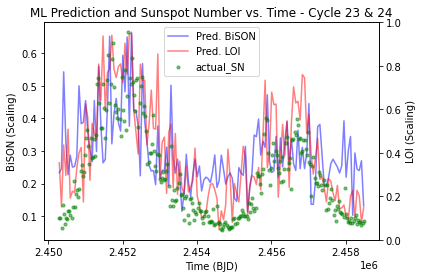

In [245]:
figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')

print(pred_BiSON.shape, SN_ts_full_fit.T[0].shape)

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('BiSON (Scaling)')
#axis_1.scatter(SN_ts_full_fit.T[0],pred_BiSON, s = 10, c='blue', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([SN_ts_full_fit.T[0],pred_BiSON]).T,140)
axis_1.plot(x1_ITP, y1_ITP, c='blue', alpha=0.5, label = "Pred. BiSON")

# #Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('LOI (Scaling)')
#axis_2.scatter(SN_ts_full_fit.T[0],pred_LOI, s = 10, c='red', alpha=0.5, label="pred_LOI")
x2_ITP, y2_ITP = interpolate(np.array([SN_ts_full_fit.T[0],pred_LOI]).T,140)
axis_1.plot(x2_ITP, y2_ITP, c='red', alpha=0.5, label = "Pred. LOI")

#Axis 3
axis_3 = axis_1.twinx()
axis_3.axis("off")
axis_3.set_ylabel('SN')
axis_3.scatter(SN_ts_full_fit.T[0],SN_ts_full_fit.T[1], s = 10, c='green', alpha=0.5, label="actual_SN")

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines_3, labels_3 = axis_3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.savefig('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Graphs/BiSON_LOI_SN.png')
plt.show()

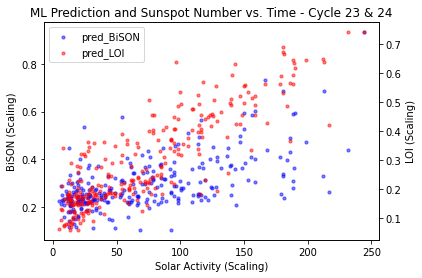

In [246]:
figure, axis_1 = plt.subplots()
plt.xlabel('Solar Activity (Scaling)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('BiSON (Scaling)')
axis_1.scatter(SN_ts_full_fit.T[1],pred_BiSON, s = 10, c='blue', alpha=0.5, label="pred_BiSON")

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('LOI (Scaling)')
axis_2.scatter(SN_ts_full_fit.T[1],pred_LOI, s = 10, c='red', alpha=0.5, label="pred_LOI")

# #Axis 3
# axis_3 = axis_1.twinx()
# axis_3.axis("off")
# axis_3.set_ylabel('SN')
# axis_3.scatter(datax_SN,datay_SN, s = 10, c='green', alpha=0.5, label="actual_SN")

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
# lines_3, labels_3 = axis_3.get_legend_handles_labels()
lines = lines_1 + lines_2 #+ lines_3
labels = labels_1 + labels_2 #+ labels_3
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.savefig('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Graphs/BiSON_LOI_SN.png')
plt.show()

In [247]:
sn_ts_full_fit_norm = normalize1D(SN_ts_full_fit.T[1])
BiSONxSN_mse = np.sqrt(mean_squared_error(sn_ts_full_fit_norm,pred_BiSON))
BiSONxSN_mae = mean_absolute_error(sn_ts_full_fit_norm,pred_BiSON)
print("BiSON vs. Actual - Mean Sq. Error, Mean Abs. Error")
print(BiSONxSN_mse,BiSONxSN_mae)

BiSON vs. Actual - Mean Sq. Error, Mean Abs. Error
0.1804711934502041 0.14606198889940158


In [248]:
LOIxSN_mse = np.sqrt(mean_squared_error(sn_ts_full_fit_norm,pred_LOI))
LOIxSN_mae = mean_absolute_error(sn_ts_full_fit_norm,pred_LOI)
print("LOI vs. Actual - Mean Sq. Error, Mean Abs. Error")
print(LOIxSN_mse,LOIxSN_mae)

LOI vs. Actual - Mean Sq. Error, Mean Abs. Error
0.11906716140703084 0.09312631991759884


In [249]:
BiSONxLOI_mse = np.sqrt(mean_squared_error(pred_BiSON,pred_LOI))
BiSONxLOI_mae = mean_absolute_error(pred_BiSON,pred_LOI)
print("BiSON vs. LOI - Mean Sq. Error, Mean Abs. Error")
print(BiSONxLOI_mse,BiSONxLOI_mae)

BiSON vs. LOI - Mean Sq. Error, Mean Abs. Error
0.13481528 0.10936022


In [147]:
def getData(koi_name,skipfront=0):
  search_result = lk.search_lightcurve(koi_name, author='Kepler', cadence="short")
  lc_test = search_result.download_all().stitch()
  lc_test = lc_test.fill_gaps()
  lc_table = lc_test.to_table()
  lc_array = np.array(lc_table['flux'])[skipfront*1440:]
  lcdatax = np.arange(0,len(lc_array)/1440,1/1440)
  lcfull = np.append([lcdatax],[lc_array],0).T
  return lcfull

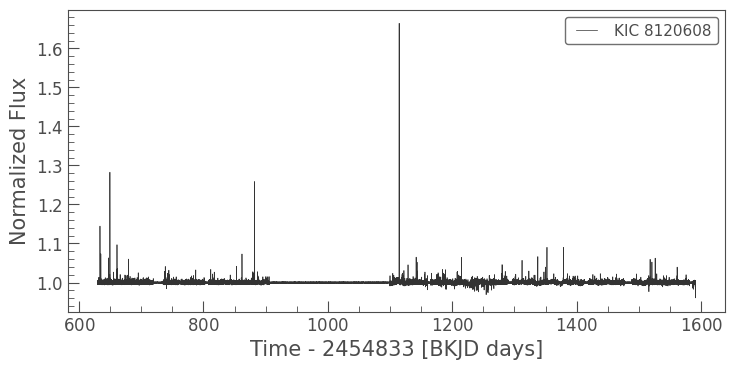

In [197]:
  search_result = lk.search_lightcurve("KIC 8120608", author='Kepler', cadence="short")
  lc_test = search_result.download_all().stitch()
  lc_test = lc_test.fill_gaps()
  lc_test.plot()

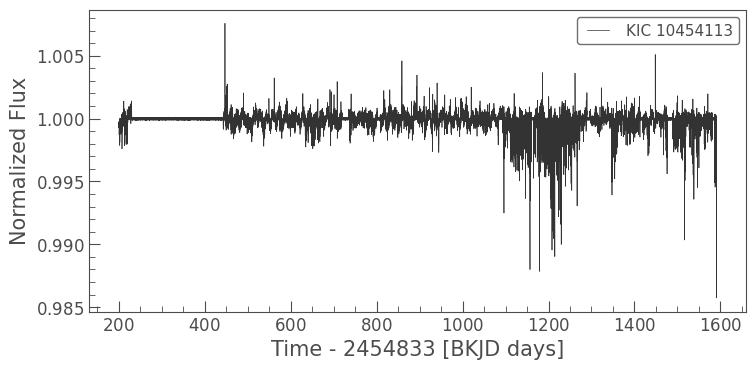

In [199]:
search_result = lk.search_lightcurve("KIC 10454113", author='Kepler', cadence="short")
lc_test = search_result.download_all().stitch()
lc_test = lc_test.fill_gaps()
lc_test.plot()

In [200]:
def prepData(data):
  power, numax = tsPower(data.T[0],data.T[1],90,30)
  power = normalize2D(power,"LOI")
  return power,numax

In [149]:
def predData(power):
  pred = model.predict(power).reshape(-1)
  return pred

In [201]:
def getSlice(data):
  power, numax = tsPower(data.T[0],data.T[1],90,30)
  return normalize2D(power)

In [209]:
def to3D(data):
  return data.reshape(data.shape[0],1,data.shape[1])

In [179]:
lc1 = getData("KIC 10454113",400)
lc2 = getData("KIC 8006161",400)
lc3 = getData("KIC 6116048",400)

In [192]:
#lc4 = getData("KIC 6444896",400)
lc5 = getData("KIC 8120608")

In [182]:
lc1_prep,p1 = prepData(lc1)
lc2_prep,p2 = prepData(lc2)
lc3_prep,p3 = prepData(lc3)

In [193]:
lc5_prep,p5 = prepData(lc5)
lc5_prep = lc5_prep.reshape(lc5_prep.shape[0],1,lc5_prep.shape[1])

In [183]:
IS_3D = True
if IS_3D:
    lc1_prep = lc1_prep.reshape(lc1_prep.shape[0],1,lc1_prep.shape[1])
    lc2_prep = lc2_prep.reshape(lc2_prep.shape[0],1,lc2_prep.shape[1])
    lc3_prep = lc3_prep.reshape(lc3_prep.shape[0],1,lc3_prep.shape[1])

In [255]:
pred1 = predData(lc1_prep)
pred2 = predData(lc2_prep)
pred3 = predData(lc3_prep)

print(pred1[0:10])

[0.47090393 0.44702685 0.46050575 0.6445949  0.45859846 0.60380745
 0.531919   0.49306592 0.42867878 0.62432826]


In [194]:
pred5 = predData(lc5_prep)
print(pred5)
print(len(pred5),len(pred3))

[0.09237891 0.1101785  0.11569811 0.07759851 0.07987424 0.08046253
 0.09100252 0.08379169 0.08713545 0.42765826 0.98628867 0.6799362
 0.83036155 0.6669282  0.36242563 0.11794683 0.10803081 0.09650895
 0.37925673 0.6012472  0.75068533 0.17945734 0.13500369 0.10754307
 0.10010922 0.08726926 0.08554039 0.09195538 0.08714572 0.09355615
 0.09474806 0.35346517]
32 32


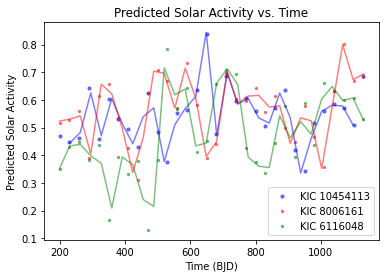

In [256]:
#figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.ylabel("Predicted Solar Activity")
plt.title('Predicted Solar Activity vs. Time')

lc_predy1 = pred1
lc_predy2 = pred2
lc_predy3 = pred3

lc_predx = np.arange(200,int(len(lc_predy1))*30+200,30)

#Axis 1
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(lc_predx,lc_predy1, s = 10, c='blue', alpha=0.5, label="KIC 10454113")
x1_ITP, y1_ITP = interpolate(np.array([lc_predx,lc_predy1]).T,30)
plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='blue', alpha=0.5)

#axis_2 = axis_1.twinx()
#axis_2.set_ylabel('LOI (Scaling)')
plt.scatter(lc_predx,lc_predy2, s = 5, c='red', alpha=0.5, label="KIC 8006161")
x2_ITP, y2_ITP = interpolate(np.array([lc_predx,lc_predy2]).T,30)
plt.plot(x2_ITP, y2_ITP, c='red', alpha=0.5)

#axis_3 = axis_1.twinx()
#axis_3.set_ylabel('LOI (Scaling)')
plt.scatter(lc_predx,lc_predy3, s = 5, c='green', alpha=0.5, label="KIC 6116048")
x2_ITP, y2_ITP = interpolate(np.array([lc_predx,lc_predy3]).T,30)
plt.plot(x2_ITP, y2_ITP, c='green', alpha=0.5)

plt.legend()
plt.show()

In [290]:
exohost = [1871056,8120608,2571238,2692377,3632418,3544595,11968749] #11554100,
#First 6 Exoplanet, Last red giant

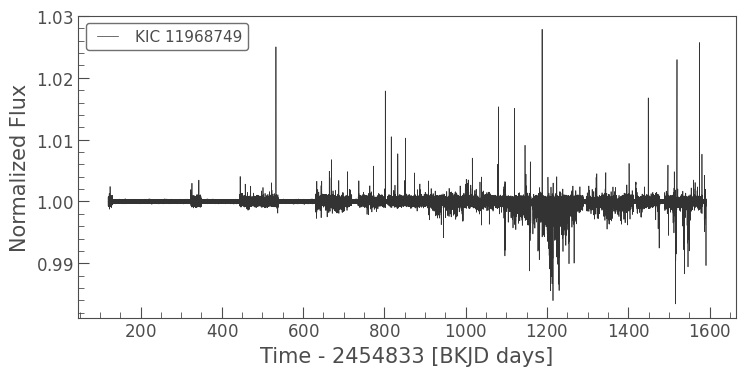

In [321]:
search_result = lk.search_lightcurve("KIC 11968749", author='Kepler', cadence="short")
lc_test = search_result.download_all().stitch()
lc_test = lc_test.fill_gaps()
lc_test.plot()

In [291]:
exohost_data = []
for star in exohost:
  exohost_data.append(getData(("KIC "+str(star))))

In [316]:
print(exohost_data[0][0])

[0.         0.99948037]


In [293]:
exohost_prep = []
for stardata in exohost_data:
  exohost_prep.append(prepData(stardata)[0])

In [294]:
for i in range(len(exohost_prep)):
  exohost_prep[i] = to3D(exohost_prep[i])

In [295]:
exohost_pred = []
for starpred in exohost_prep:
  exohost_pred.append(predData(starpred))

In [275]:
def addFiller(data,totallength):
  while len(data) < totallength:
    data = np.append(data,0.5)
  return data

In [276]:
def findMaxLen(data): 
    maxLength = max(len(x) for x in data) 
    return maxLength 

In [296]:
exohost_fill = []
maxlen2 = findMaxLen(exohost_pred)
for starpred in exohost_pred:
  exohost_fill.append(addFiller(starpred,maxlen))

In [297]:
print(exohost_fill)

[array([0.40717149, 0.61508608, 0.86041331, 0.47961378, 0.65414518,
       0.28521717, 0.18561058, 0.17089973, 0.31407827, 0.37242618,
       0.38891083, 0.34466285, 0.46319506, 0.41501439, 0.42025676,
       0.36596033, 0.2253909 , 0.16889063, 0.25218663, 0.35439894,
       0.28750786, 0.2168349 , 0.30867091, 0.20334585, 0.32426426,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       ]), array([0.13109997, 0.16589361, 0.19313246, 0.11593385, 0.11063643,
       0.12147345, 0.13524629, 0.13308223, 0.13220154, 0.5278492 ,
       0.61974901, 0.706918  , 0.51084524, 0.6615544 , 0.2912893 ,
       0.16342992, 0.13776749, 0.1381115 , 0.38298157, 0.42963997,
       0.39034691, 0.247834  , 0.22865333, 0.13928601, 0.13490841,
    

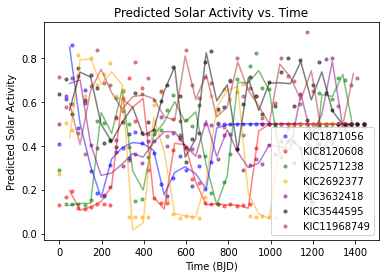

In [299]:
plt.xlabel('Time (BJD)')
plt.ylabel("Predicted Solar Activity")
plt.title('Predicted Solar Activity vs. Time')

maxlen = findMaxLen(exohost_fill)
lcx = np.arange(0,maxlen*30,30)

plt.autoscale(enable=True, axis='both', tight=None)

# for i in range(len(exohost_fill)):
#   plt.scatter(lcx,exohost_fill[i], s = 10, c='blue', alpha=0.5, label=("KIC"+str(exohost[i])))
#   x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[i]]).T,30)
#   plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='blue', alpha=0.5)
plt.scatter(lcx,exohost_fill[0], s = 10, c='blue', alpha=0.5, label=("KIC"+str(exohost[0])))
x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[0]]).T,30)
plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='blue', alpha=0.5)

plt.scatter(lcx,exohost_fill[1], s = 10, c='red', alpha=0.5, label=("KIC"+str(exohost[1])))
x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[1]]).T,30)
plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='red', alpha=0.5)

plt.scatter(lcx,exohost_fill[2], s = 10, c='green', alpha=0.5, label=("KIC"+str(exohost[2])))
x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[2]]).T,30)
plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='green', alpha=0.5)

plt.scatter(lcx,exohost_fill[3], s = 10, c='orange', alpha=0.5, label=("KIC"+str(exohost[3])))
x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[3]]).T,30)
plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='orange', alpha=0.5)
plt.scatter(lcx,exohost_fill[4], s = 10, c='purple', alpha=0.5, label=("KIC"+str(exohost[4])))
x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[4]]).T,30)
plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='purple', alpha=0.5)
plt.scatter(lcx,exohost_fill[5], s = 10, c='black', alpha=0.5, label=("KIC"+str(exohost[5])))
x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[5]]).T,30)
plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='black', alpha=0.5)
plt.scatter(lcx,exohost_fill[6], s = 10, c='brown', alpha=0.5, label=("KIC"+str(exohost[6])))
x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[6]]).T,30)
plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='brown', alpha=0.5)

# plt.scatter(lcx,exohost_fill[3], s = 10, c='purple', alpha=0.5, label=("KIC"+str(exohost[3])))
# x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[3]]).T,30)
# plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='purple', alpha=0.5)


plt.legend()
plt.show()

TypeError: ignored

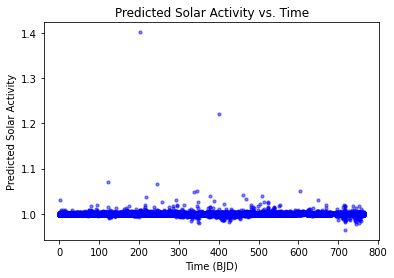

In [315]:
plt.xlabel('Time (BJD)')
plt.ylabel("Predicted Solar Activity")
plt.title('Predicted Solar Activity vs. Time')

# maxlen = len(exohost_data[0])
# lcx = np.arange(0,maxlen)

plt.autoscale(enable=True, axis='both', tight=None)

# for i in range(len(exohost_fill)):
#   plt.scatter(lcx,exohost_fill[i], s = 10, c='blue', alpha=0.5, label=("KIC"+str(exohost[i])))
#   x1_ITP, y1_ITP = interpolate(np.array([lcx,exohost_fill[i]]).T,30)
#   plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='blue', alpha=0.5)
plt.scatter(exohost_data[0].T[0],exohost_data[0].T[1], s = 10, c='blue', alpha=0.5)
x1_ITP, y1_ITP = interpolate(np.array(exohost_data[0].T[0],exohost_data[0].T[1]).T,30)
plt.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='blue', alpha=0.5)

plt.show()

## Compare Datasets

In [ ]:
#23
#   print(BiSON_ts_23.shape,SN_ts_23.shape,LOI_ts_23.shape)

#24
#   print(BiSON_ts_24_fit.shape,SN_ts_24_fit.shape,LOI_ts_24.shape)

#Full
#   print(BiSON_ts_full_fit.shape,SN_ts_full_fit.shape,LOI_ts_full.shape)
y1 = normalize2D(BiSON_ts_full_fit)[0]
y2 = normalize2D(LOI_ts_full)[0]
y3 = lc1_prep[0]

In [ ]:
def filterPg(pg):
  discard = 0.3
  for i in range(int(len(pg))):
    if pg[i] <= discard:
      pg[i] = 0
  #   else:
  #     pg[i] -= discard
  # pg = np.divide(pg,np.max(pg))
  return pg

[ 992. 1380. 1622. 2132. 2916. 3371. 4148. 4526. 4939. 5290. 5836. 6571.
 6951. 7354.] [0.44721106 0.49577136 0.56318943 0.54038116 1.         0.39177608
 0.36370707 0.53226221 0.47128111 0.35626258 0.50778757 0.52390755
 0.55922793 0.35757202 0.44401813 0.04963992]
7776


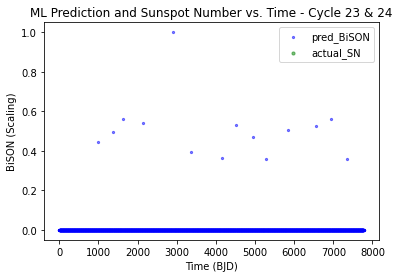

In [ ]:
figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')
# for i in range(len(y3)):
#   if y3[i] < 0.4:
#     y3[i] = 0
# print(y3[0])
  

x1 = np.arange(0,7776)

y4 = []
for value in x1:
    check = True
    for i in range(int(len(tfreqs))):
        if int(tfreqs[i]-1) == value:
            y4 = np.append(y4,tmodes[i])
            check = False
            break
    if check:
        y4 = np.append(y4,0)

print(len(y4))

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('BiSON (Scaling)')
axis_1.scatter(x1,y4, s = 5, c='blue', alpha=0.5, label="pred_BiSON")
# x1_ITP, y1_ITP = interpolate(np.array([x1,y1]).T,50)
# axis_1.plot(x1_ITP, y1_ITP, c='blue', alpha=0.5, label = "Pred. BiSON")

# # #Axis 2
# axis_2 = axis_1.twinx()
# axis_2.set_ylabel('LOI (Scaling)')
# axis_2.scatter(x1,y2, s = 5, c='red', alpha=0.5, label="pred_LOI")
# x2_ITP, y2_ITP = interpolate(np.array([x1,y2]).T,50)
# axis_1.plot(x2_ITP, y2_ITP, c='red', alpha=0.5, label = "Pred. LOI")

# #Axis 3
# axis_3 = axis_1.twinx()
# axis_3.axis("off")
# axis_3.set_ylabel('SN')
# axis_3.scatter(x1,y4, s = 5, c='green', alpha=0.5, label="actual_SN")

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines_3, labels_3 = axis_3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
axis_1.legend(lines, labels, loc=0)
plt.show()

In [ ]:
lk.seismology.estimate_deltanu_acf2d?

## Test Code

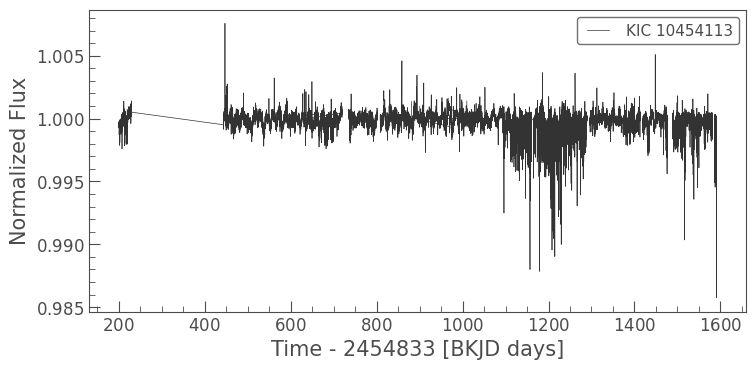

In [ ]:
search_result = lk.search_lightcurve('KIC 10454113', author='Kepler', cadence="short")
search_result
lc_test = search_result.download_all().stitch()
lc_test.plot()

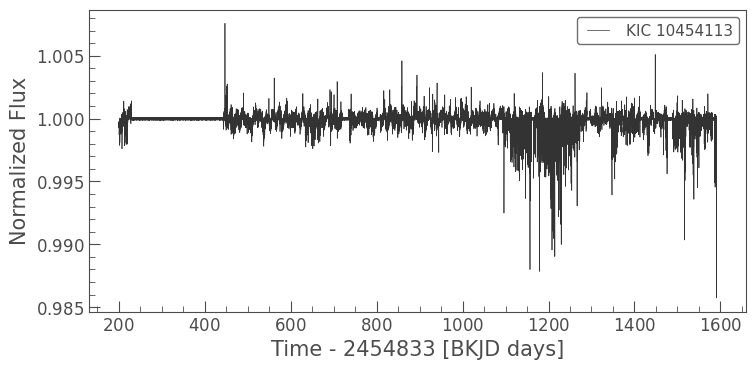

In [ ]:
lc_test = lc_test.fill_gaps()
lc_test.plot()

In [ ]:
Dlc_table = lc_test.to_table()
lc_array = np.array(lc_table['flux'])
print(lc_array)

In [ ]:
lcdatax = np.arange(0,len(lc_array)/1440,1/1440)
lcfull = np.append([lcdatax],[lc_array],0).T
print(lcfull.shape)

(1996170, 2)


In [ ]:
print(lcfull[-1])

[1.38622847e+03 1.00039232e+00]


In [ ]:
lc_power, lc_numax = tsPower(lcfull.T[0],lcfull.T[1],90,30)

In [ ]:
print(lc_power.shape,lc_numax)

(44, 7776) 1425


In [ ]:
lc_power_norm = normalize2D(lc_power)
print(np.max(lc_power_norm))

1.0


In [ ]:
pred_lc = model.predict(lc_power_norm[9:]).reshape(-1)
print(pred_lc.shape)
print(pred_lc)

(35,)
[2.1501856 2.1978247 2.218618  1.9813035 1.8138002 1.6447774 1.7670627
 1.3543344 1.6227567 1.4145533 1.6896728 1.8097239 1.6240644 2.0843878
 2.0923507 1.9381614 2.283571  2.4614487 2.109753  1.9923794 2.4358625
 2.504476  2.693074  2.2238019 2.4378045 2.00395   1.5316311 2.0904558
 1.6939368 1.8036245 1.837662  1.5059265 2.7730196 2.3647003 2.3227234]


<function matplotlib.pyplot.show>

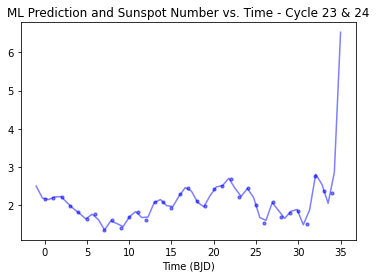

In [ ]:
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')

lc_testx = np.arange(0,int(len(pred_lc)))

#Axis 1
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(lc_testx,pred_lc, s = 10, c='blue', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([lc_testx,pred_lc]).T,50)
plt.plot(x1_ITP, y1_ITP, c='blue', alpha=0.5, label = "Pred. BiSON")

plt.show

In [ ]:
lcdata3 = getData("KIC 6116048")

In [ ]:
lc_power, lc_numax = tsPower(lcdata3.T[0],lcdata3.T[1],90,30)

In [ ]:
lc_power_norm = normalize2D(lc_power)
print(np.max(lc_power_norm))

1.0


In [ ]:
pred_lc = model.predict(lc_power_norm[9:]).reshape(-1)
print(pred_lc.shape)
print(pred_lc)

(36,)
[0.5277961  0.63132465 0.40478465 0.42059588 0.5209544  0.7009002
 1.031577   0.7302094  0.58843035 0.5559162  0.57662654 0.58658266
 0.5535707  0.4052446  0.38021135 0.54982436 1.748396   1.4241097
 2.086725   1.1885546  1.8470598  1.8879963  1.9531791  1.8862461
 1.4063263  1.131757   1.1278707  1.4685751  1.067278   1.2002715
 1.1034241  0.6847471  0.71507204 1.2039894  1.3913287  1.1852996 ]


In [ ]:
lcdata4 = getData("KIC 12009504")

In [ ]:
lc_power2, lc_numax2 = tsPower(lcdata4.T[0],lcdata4.T[1],90,30)

In [ ]:
lc_power_norm2 = normalize2D(lc_power2)
print(np.max(lc_power_norm2))
pred_lc2 = model.predict(lc_power_norm2[9:-2]).reshape(-1)
print(pred_lc2.shape)
print(pred_lc2)

1.0
(36,)
[1.0906223  1.0631001  1.0119612  1.1853065  1.2532316  0.87308747
 0.9431411  0.9877703  1.6166066  1.683091   1.5640908  0.886065
 1.0997486  1.0799937  1.2167377  0.99084055 1.1682     1.0814201
 1.524697   1.6352017  1.7068578  1.4969152  0.9861238  1.2276504
 1.0122035  1.7186154  1.7474402  2.0638342  2.1568449  1.5226185
 1.688213   1.412455   1.489743   1.0179482  1.2917794  0.8883791 ]


In [ ]:
lcdata5 = getData("KIC 8006161")

In [ ]:
lc_power3, lc_numax3 = tsPower(lcdata5.T[0],lcdata5.T[1],90,30)

In [ ]:
lc_power_norm3 = normalize2D(lc_power3)
print(np.max(lc_power_norm3))
pred_lc3 = model.predict(lc_power_norm3[9:]).reshape(-1)
print(pred_lc3.shape)
print(pred_lc3)

1.0
(36,)
[0.51671636 0.4697245  0.5306659  0.4744122  0.5324677  0.8603418
 0.8463695  0.9316367  1.2206714  1.2951821  0.85572636 0.7345146
 0.80385494 0.774252   1.3114283  1.420307   1.7812022  1.5878102
 1.1935314  1.2851081  1.3955448  2.1604865  2.4565613  1.9691529
 1.7256997  1.3129588  1.7235616  1.5142536  1.7675918  1.2173353
 0.9837395  0.6535239  2.0073683  1.9211634  1.6827221  1.8208772 ]


<function matplotlib.pyplot.show>

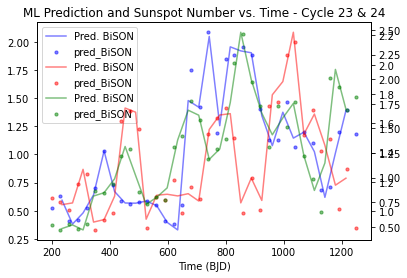

In [ ]:
figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')

lc_testx = np.arange(200,int(len(pred_lc))*30+200,30)



#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.scatter(lc_testx,pred_lc, s = 10, c='blue', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([lc_testx,pred_lc]).T,30)
axis_1.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='blue', alpha=0.5, label = "Pred. BiSON")


# #Axis 2
axis_2 = axis_1.twinx()
axis_2.scatter(lc_testx,pred_lc2, s = 10, c='red', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([lc_testx,pred_lc2]).T,30)
axis_2.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='red', alpha=0.5, label = "Pred. BiSON")


# #Axis 3
axis_3 = axis_1.twinx()
axis_3.scatter(lc_testx,pred_lc3, s = 10, c='green', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([lc_testx,pred_lc3]).T,30)
axis_3.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='green', alpha=0.5, label = "Pred. BiSON")

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines_3, labels_3 = axis_3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
axis_1.legend(lines, labels, loc=0)


plt.show